# Immersed Cylinder benchmarking

![image](close_up.png)

This notebook will contain all the required scripts and commands to produce the
benchmarking for the immersed cylinder case. This requires the following steps:

We expect the simulation for the `cylinder_benchmark` example have been
completed and that the resulting data is available in the `cylinder_benchmark`
subdirectory of the results folder.

The benchmarking consists of a few different sub-benchmarks:

1. Inflection point detection.
2. Backdraft region detection.
3. Leakage detection.

In [121]:
# Setup the paths for the project and load the external modules

# Install any missing dependencies and setup the paths for the project
try:
    import numpy as np
    import matplotlib.pyplot as plt
except:
    %pip install numpy matplotlib
    import numpy as np
    import matplotlib.pyplot as plt

# Load the external modules
import sys
import os

# Load internal modules
sys.path.append('modules')
from nekotop import *

# Setup the paths for the project
path = os.path.realpath(
    os.path.join(os.getcwd(), '../results/cylinder_benchmark'))

# Check that the folder exists
if not os.path.exists(path):
    print("The path to the results folder does not exist.")
    print("Please run the benchmark first.")
    print("\tcd NEKO_TOP_ROOT")
    print("\t./setup.sh")
    print("\t./run.sh cylinder_benchmark")
    exit(404)


## Inflection point detection

The inflection points we are looking for are the points where the fluid around
the cylinder changes sign. These will move as vortices are formed and shed. We
are interested in detecting these points and tracking them over time.

### Processing the data

The first step is to post-process the data to extract the inflection points.
This is done by probing the velocity field in a circle around the cylinder and
detecting the points where the velocity changes sign. Each point will be
converted to just an angle and a time, as the radius of the circle is fixed.


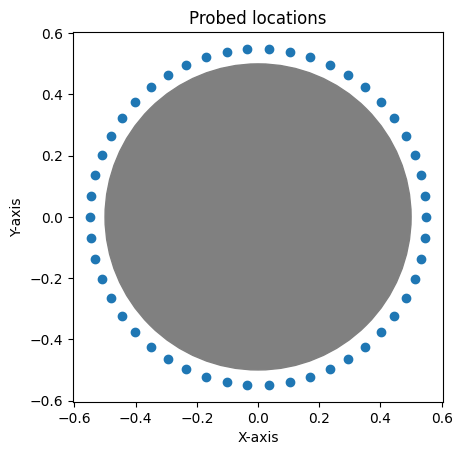

In [122]:
# Read in the file and setup the data
file_name = 'meshed_inflection.csv'

# Check that the file exists
if not os.path.exists(file_name):
    file_name = os.path.join(path, file_name)
    if not os.path.exists(file_name):
        print("The file does not exist.")
        exit(404)

# If the points variable is not initialized, read in the data
if not 'is_initialized' in locals():
    points, fields, times, field_names = read_probes(file_name)
    N_points = points.shape[0]
    N_fields = fields.shape[1]
    N_times = times.shape[0]
    is_initialized = True

# Plot the points in a 2D plot. (Z-axis should be constant)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(points[:, 0], points[:, 1])

# Add a circle for the cylinder boundary with radius 0.5
circle = plt.Circle((0, 0), 0.5, color='gray', fill=True)
ax.add_artist(circle)

ax.set_aspect('equal')
plt.title("Probed locations")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


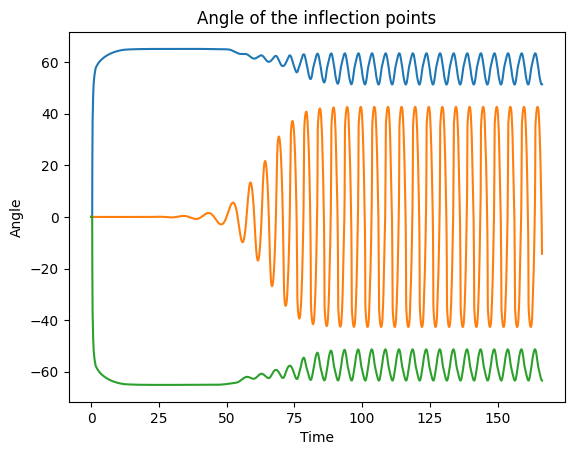

In [123]:
# Compute the inflection angles for all time steps
if not 'angles' in locals():
    center = np.array([0.0, 0.0, 0.0])
    angles = track_inflection_point(center, points, fields, times)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(times, angles * 360.0 / (2.0 * np.pi))

plt.title("Angle of the inflection points")
plt.xlabel("Time")
plt.ylabel("Angle")
plt.show()


### Detection of stable regions

The next step is to detect the regions where the inflection points are stable.
This is done by examining the time series of the inflection points and
detecting the regions where the oscillations are stable, i.e. the points are
oscillating around a fixed point with a fixed amplitude.

In general we will see 3 regions of interest:

1. The build-up of boundary layers. Here we will see the inflection points move
   from a central point close to the 0 angle to the final stable position.
3. Build-up of vortices. Here we will see the inflection points move from the
   stable position and begin to oscillate with increasing amplitude.
4. Shedding of vortices. Here we will see the inflection points oscillate with
   a large, but stable, amplitude.

In [124]:
# Detect the boundary layer formation.
#
# The layer formation is detected when the inflection points stabilize after the
# initial move.

# Compute the difference between the inflection points
diff = np.diff(angles, axis=0)
diff = np.abs(diff)

i_boundary = 0
max_diff = 0.0
threshold = 1e-6

for i_boundary in range(len(times)):
    if diff[i_boundary, :].max() < threshold and max_diff > threshold:
        break

    max_diff = max(max_diff, diff[i_boundary, :].max())

if i_boundary == len(times):
    print("The layer formation is not detected.")
    exit(1)

print("The layer formation is detected at time: ", times[i_boundary])

The layer formation is detected at time:  13.647999999997875


In [125]:
# Detection of the build up of the vortex.
#
# The vortex building is detected when the inflection points have stabilized
# into a periodic motion.

i_building = 0
threshold = 1e-6
min_signal = np.array(angles[i_boundary, :], copy=True)
max_signal = np.array(angles[i_boundary, :], copy=True)
for i in range(i_boundary, len(times)):

    criterion_min = min(angles[i, :] - min_signal) < - threshold
    criterion_max = min(max_signal - angles[i, :]) < - threshold

    max_signal = np.maximum(max_signal, angles[i, :])
    min_signal = np.minimum(min_signal, angles[i, :])

    if criterion_min or criterion_max:
        i_building = i


print("The vortex building is detected at time: ", times[i_building])


The vortex building is detected at time:  131.18700000026234


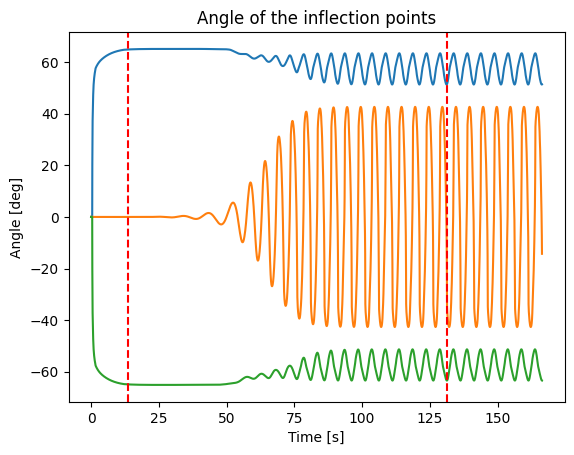

In [126]:
# Inspection of the detected regions and isolation of test set.

# Extract the data for the stable region
times_stable = times[i_building:]
angles_stable = angles[i_building:, :]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(times, angles * 360.0 / (2.0 * np.pi))

ax.axvline(x=times[i_boundary], color='r', linestyle='--')
ax.axvline(x=times[i_building], color='r', linestyle='--')

plt.title("Angle of the inflection points")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")
plt.show()

### Computation of statistics

The final step is to compute the statistics of the stable vortex shedding
region. This will include the frequency of the oscillations, the amplitude of
the oscillations and the phase shift between the different inflection points.

All of these measures are only interesting once the vortex shedding have reached
a stable oscillatory state. This is typically after the boundary layers have
formed and the vortices have started to shed.

1. The frequency is computed using a Fourier transform of the time series of the
   inflection angles.
2. The amplitude is computed as the maximum deviation from the mean of the
   inflection angles.


The dominant frequency for the inflection point  0  is:  0.1987789294325309 Hz
The dominant frequency for the inflection point  1  is:  0.1987789294325309 Hz
The dominant frequency for the inflection point  2  is:  0.1987789294325309 Hz


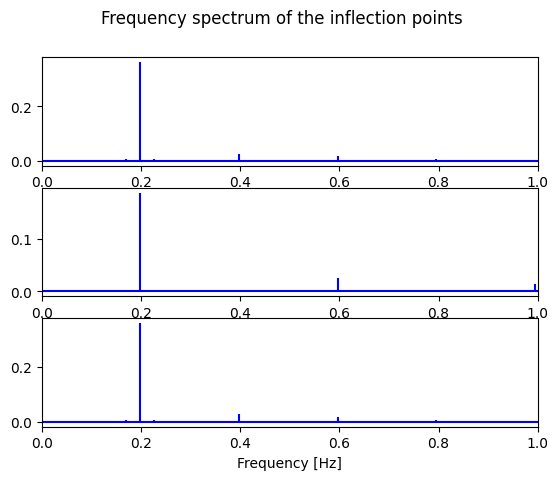

In [127]:
# Compute the frequency spectrum of the inflection points
#
# Detect the frequencies present in the inflection point signals display them as
# frequency spectrum. This should allow us to classify the dominant frequencies.

test_times = times[i_building:]
test_angles = angles[i_building:, :]

# Compute the frequency spectrum of the signals
frequencies = np.fft.fftfreq(len(test_times), d=test_times[1] - test_times[0])
frequencies = np.fft.fftshift(frequencies)

spectrum = np.zeros([len(frequencies), 3], dtype=complex)
for i in range(3):
    spectrum[:, i] = np.fft.fft(test_angles[:, i] - test_angles[:, i].mean())
    spectrum[:, i] = np.fft.fftshift(spectrum[:, i])

    # Normalize the spectrum
    spectrum[:, i] /= sum(np.abs(spectrum[:, i]))

# Print the dominant frequencies
max_freq = np.zeros(3)
for i in range(3):
    idx = np.argmax(np.abs(spectrum[:, i]))
    max_freq[i] = np.abs(frequencies[idx])
    print("The dominant frequency for the inflection point ", i,
        " is: ", max_freq[i], "Hz")

fig = plt.figure()
fig.clf()

ax0 = fig.add_subplot(311)
plt.stem(frequencies, np.abs(spectrum[:, 0]), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlim([0, 1])

ax1 = fig.add_subplot(312)
plt.stem(frequencies, np.abs(spectrum[:, 1]), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlim([0, 1])

ax2 = fig.add_subplot(313)
plt.stem(frequencies, np.abs(spectrum[:, 2]), 'b', \
         markerfmt=" ", basefmt="-b")
plt.xlim([0, 1])

plt.suptitle("Frequency spectrum of the inflection points")
plt.xlabel("Frequency [Hz]")
plt.show()


In [128]:
# Compute the amplitude of the inflection points
#
# Compute the amplitude of the inflection points and display them as a function
# of time. This should allow us to classify the dominant amplitudes.
# The amplitude are computed as the difference between the maximum and minimum
# deviation from the mean of the inflection points.

amplitude = [
    (test_angles[:, 0] - test_angles[:, 0].mean()).max()
    - (test_angles[:, 0] - test_angles[:, 0].mean()).min(),
    (test_angles[:, 1] - test_angles[:, 1].mean()).max()
    - (test_angles[:, 1] - test_angles[:, 1].mean()).min(),
    (test_angles[:, 2] - test_angles[:, 2].mean()).max()
    - (test_angles[:, 2] - test_angles[:, 2].mean()).min()
]
print("The dominant amplitude for the inflection points are: ", amplitude)


The dominant amplitude for the inflection points are:  [0.2113557754973352, 1.4893004157707863, 0.21136270261469592]
